In [1]:

!pip install librosa==0.9.2 audiomentations==0.24.0 soundfile --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 121.6 MB/s eta 0:00:00


In [2]:
import kagglehub
import os
import glob
import pandas as pd
import librosa
import numpy as np
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [7]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("orvile/ravdess-dataset")
crema_path = kagglehub.dataset_download("ejlok1/cremad")
print("CREMA-D path:", crema_path)
print("Path to dataset files:", path)

Resuming download from 195035136 bytes (25419989106 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/orvile/ravdess-dataset?dataset_version_number=1 (195035136/25615024242) bytes left.


100%|██████████| 23.9G/23.9G [18:31<00:00, 22.9MB/s]

Extracting files...


Using Colab cache for faster access to the 'cremad' dataset.
CREMA-D path: /kaggle/input/cremad
Path to dataset files: /root/.cache/kagglehub/datasets/orvile/ravdess-dataset/versions/1


In [8]:
import os
import glob
import pandas as pd
# We will work on audio speech actors only for now
files = glob.glob(path+ '/Audio_Speech_Actors_01-24' + '/**/*.wav', recursive=True)
crema_files = glob.glob(os.path.join(crema_path, "AudioWAV", "*.wav"))
print("CREMA-D found:", len(crema_files))
print("Example:", crema_files[0])
print("Total files found:", len(files))
print("Example:", files[0])


CREMA-D found: 7442
Example: /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
Total files found: 1440
Example: /root/.cache/kagglehub/datasets/orvile/ravdess-dataset/versions/1/Audio_Speech_Actors_01-24/Actor_06/03-01-04-01-02-02-06.wav


In [9]:
def parse_crema_filename(path):
    fname = os.path.basename(path)
    parts = fname.split('_')

    emotion_code = parts[2]   # e.g., HAP → we only use the first letter

    emotion_map = {
        "A": "angry",
        "D": "disgust",
        "F": "fearful",
        "H": "happy",
        "N": "neutral",
        "S": "sad",
    }

    return {
        "path": path,
        "emotion": emotion_map[emotion_code[0]]
    }

def parse_ravdess_filename(filename):
    parts = os.path.basename(filename).split('.')[0].split('-')

    info = {
        "path": filename,
        "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}[parts[0]],
        "vocal_channel": {"01": "speech", "02": "song"}[parts[1]],
        "emotion": {
            "01": "neutral",
            "02": "calm",
            "03": "happy",
            "04": "sad",
            "05": "angry",
            "06": "fearful",
            "07": "disgust",
            "08": "surprised"
        }[parts[2]],
        "intensity": {"01": "normal", "02": "strong"}[parts[3]],
        "statement": {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}[parts[4]],
        "repetition": {"01": "1st", "02": "2nd"}[parts[5]],
        "actor": int(parts[6]),
    }
    info["gender"] = "male" if info["actor"] % 2 != 0 else "female"
    return info


In [10]:
crema_data = [parse_crema_filename(f) for f in crema_files]
df_crema = pd.DataFrame(crema_data)
df_crema.head()

data = [parse_ravdess_filename(f) for f in files]
df_rav = pd.DataFrame(data)
df_rav.head()

df_all = pd.concat([df_rav[["path","emotion"]], df_crema], ignore_index=True)
print("Total combined samples:", len(df_all))
df_all['emotion'].value_counts()


Total combined samples: 8882


,count
emotion,
sad,1463
angry,1463
disgust,1463
fearful,1463
happy,1463
neutral,1183
surprised,192
calm,192


In [11]:
print(f"Original shape: {len(df_all)}")
print("--- BEFORE MERGE ---")
print(df_all['emotion'].value_counts())

# Merge 'disgust' into 'angry'
df_all['emotion'] = df_all['emotion'].replace('disgust', 'angry')

print(f"\n--- AFTER MERGE ---")
print(f"Shape after merging: {len(df_all)}")
print(df_all['emotion'].value_counts())

Original shape: 8882
--- BEFORE MERGE ---
emotion
sad          1463
angry        1463
disgust      1463
fearful      1463
happy        1463
neutral      1183
surprised     192
calm          192
Name: count, dtype: int64

--- AFTER MERGE ---
Shape after merging: 8882
emotion
angry        2926
sad          1463
fearful      1463
happy        1463
neutral      1183
surprised     192
calm          192
Name: count, dtype: int64


In [12]:
data = [parse_ravdess_filename(f) for f in files]
df = pd.DataFrame(data)
df.head()

,path,modality,vocal_channel,emotion,intensity,statement,repetition,actor,gender
0,/root/.cache/kagglehub/datasets/orvile/ravdess...,audio-only,speech,sad,normal,Dogs are sitting by the door,2nd,6,female
1,/root/.cache/kagglehub/datasets/orvile/ravdess...,audio-only,speech,sad,strong,Kids are talking by the door,1st,6,female
2,/root/.cache/kagglehub/datasets/orvile/ravdess...,audio-only,speech,angry,normal,Kids are talking by the door,2nd,6,female
3,/root/.cache/kagglehub/datasets/orvile/ravdess...,audio-only,speech,surprised,normal,Kids are talking by the door,2nd,6,female
4,/root/.cache/kagglehub/datasets/orvile/ravdess...,audio-only,speech,disgust,strong,Kids are talking by the door,2nd,6,female


In [13]:
print(df["emotion"].value_counts())
print(df.groupby("gender")["emotion"].value_counts())


emotion
sad          192
angry        192
surprised    192
disgust      192
calm         192
happy        192
fearful      192
neutral       96
Name: count, dtype: int64
gender  emotion  
female  angry        96
        calm         96
        disgust      96
        fearful      96
        happy        96
        sad          96
        surprised    96
        neutral      48
male    angry        96
        calm         96
        disgust      96
        fearful      96
        happy        96
        sad          96
        surprised    96
        neutral      48
Name: count, dtype: int64


In [14]:
import librosa
import numpy as np

SR = 16000      # sample rate
DURATION = 3.0  # seconds
SAMPLES = int(SR * DURATION)

def preprocess_audio(path, sr=SR):
    # Load audio and resample directly to the target sample rate
    y, _ = librosa.load(path, sr=sr)
    if y.ndim > 1:
        y = np.mean(y, axis=1)  # to mono
    y, _ = librosa.effects.trim(y, top_db=20)
    y = y / (np.max(np.abs(y)) + 1e-6)
    if len(y) < SAMPLES:
        pad = SAMPLES - len(y)
        y = np.pad(y, (0, pad))
    else:
        y = y[:SAMPLES]
    return y

In [15]:
def to_log_mel(y, sr=SR, n_mels=128):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # normalize per-sample
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)
    return mel_db


Spec shape: (128, 94)


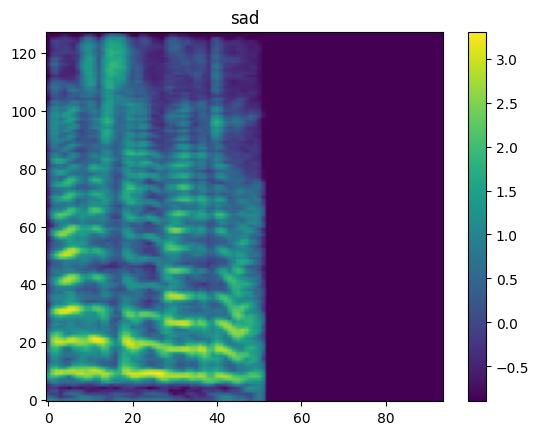

In [16]:
import matplotlib.pyplot as plt

y = preprocess_audio(df["path"].iloc[0])
spec = to_log_mel(y)
print("Spec shape:", spec.shape)

plt.imshow(spec, aspect="auto", origin="lower")
plt.title(df["emotion"].iloc[0])
plt.colorbar()
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# Split the DataFrame *before* processing
df_train, df_test = train_test_split(
    df_all,
    test_size=0.2,
    random_state=42,
    stratify=df_all['emotion']
)

print(f"Train files: {len(df_train)} | Test files: {len(df_test)}")

Train files: 7105 | Test files: 1777


In [18]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])

In [19]:
import numpy as np
from tqdm.notebook import tqdm

X_train = []
y_train = []
X_test = []
y_test = []

print("Processing and Augmenting Training Data...")
# Loop over the TRAINING files
for i in tqdm(range(len(df_train))):
    path = df_train["path"].values[i]
    emotion = df_train["emotion"].values[i]

    try:
        y = preprocess_audio(path)

        # 1. Add the ORIGINAL sample
        mel_orig = to_log_mel(y)
        X_train.append(np.expand_dims(mel_orig, axis=-1))
        y_train.append(emotion)

        # 2. Add AUGMENTED sample 1
        y_aug1 = augment(samples=y, sample_rate=SR)
        mel_aug1 = to_log_mel(y_aug1)
        X_train.append(np.expand_dims(mel_aug1, axis=-1))
        y_train.append(emotion)

        # 3. Add AUGMENTED sample 2
        y_aug2 = augment(samples=y, sample_rate=SR)
        mel_aug2 = to_log_mel(y_aug2)
        X_train.append(np.expand_dims(mel_aug2, axis=-1))
        y_train.append(emotion)

    except Exception as e:
        print(f"Error processing {path}: {e}")

print("Processing Test Data (no augmentation)...")
# Loop over the TEST files
for i in tqdm(range(len(df_test))):
    path = df_test["path"].values[i]
    emotion = df_test["emotion"].values[i]

    try:
        y = preprocess_audio(path)
        mel = to_log_mel(y)
        X_test.append(np.expand_dims(mel, axis=-1))
        y_test.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")


print("Preprocessing complete.")
print(f"New X_train shape: {len(X_train)} samples")
print(f"New X_test shape: {len(X_test)} samples")

Processing and Augmenting Training Data...


  0%|          | 0/7105 [00:00<?, ?it/s]

Processing Test Data (no augmentation)...


  0%|          | 0/1777 [00:00<?, ?it/s]

Preprocessing complete.
New X_train shape: 21315 samples
New X_test shape: 1777 samples


In [22]:
from sklearn.preprocessing import LabelEncoder

# Fit on the training labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Transform the test labels
y_test_encoded = encoder.transform(y_test)

print("Classes:", encoder.classes_)
num_classes = len(encoder.classes_)

Classes: ['angry' 'calm' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


# 1 CREATE DRIVE FOLDER (run only once)


In [28]:
from google.colab import drive
import os, numpy as np

drive.mount('/content/drive')
SAVE_DIR = '/content/drive/MyDrive/Machine Learning/Deep Learning/data'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Folder ready: {SAVE_DIR}")

Mounted at /content/drive
Folder ready: /content/drive/MyDrive/Machine Learning/Deep Learning/data


# 2 SAVE THE PRE-PROCESSED ARRAYS

In [29]:
np.save(os.path.join(SAVE_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SAVE_DIR, "y_train.npy"), y_train_encoded)
np.save(os.path.join(SAVE_DIR, "X_test.npy"), X_test)
np.save(os.path.join(SAVE_DIR, "y_test.npy"), y_test_encoded)
np.save(os.path.join(SAVE_DIR, "classes_all.npy"), encoder.classes_)

print("Saved X_train.npy, y_train.npy, X_test.npy, y_test.npy, classes_all.npy")

Saved X_train.npy, y_train.npy, X_test.npy, y_test.npy, classes_all.npy


# 3 LOAD THEM BACK (so the rest of the notebook works after a restart)

In [40]:
X_train = np.load(os.path.join(SAVE_DIR, "X_train.npy"))
y_train_encoded = np.load(os.path.join(SAVE_DIR, "y_train.npy"))
X_test = np.load(os.path.join(SAVE_DIR, "X_test.npy"))
y_test_encoded = np.load(os.path.join(SAVE_DIR, "y_test.npy"))
classes = np.load(os.path.join(SAVE_DIR, "classes_all.npy"))

print(f"X_train shape : {X_train.shape}  |  y_train shape : {y_train_encoded.shape}")
print(f"X_test shape  : {X_test.shape}  |  y_test shape  : {y_test_encoded.shape}")
print(f"Classes: {classes}")

X_train shape : (21315, 128, 94, 1)  |  y_train shape : (21315,)
X_test shape  : (1777, 128, 94, 1)  |  y_test shape  : (1777,)
Classes: ['angry' 'calm' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


4 TRAIN / VALIDATION SPLIT + ONE-HOT

In [41]:
import tensorflow as tf

num_classes = len(classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

print(f"Train samples: {X_train.shape[0]}  |  Test samples: {X_test.shape[0]}")

Train samples: 21315  |  Test samples: 1777


In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# We already have the 1D integer labels from Cell 98
# The variable is y_train_encoded

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Convert to a dictionary format that model.fit() understands
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.4335753951302862), 1: np.float64(6.590909090909091), 2: np.float64(0.8675213675213675), 3: np.float64(0.8675213675213675), 4: np.float64(1.072938689217759), 5: np.float64(0.8675213675213675), 6: np.float64(6.590909090909091)}


In [43]:
def freq_mask(spec, F=15):
    # spec shape: (batch, n_mels, time_steps, channels)
    s = tf.shape(spec)
    f = tf.random.uniform([], 0, F, dtype=tf.int32)
    f0 = tf.random.uniform([], 0, s[1] - f, dtype=tf.int32) # s[1] is n_mels

    # Create mask parts, each needs to be (batch, masked_freq_len, time_steps, channels)
    mask_before = tf.ones([s[0], f0, s[2], s[3]], dtype=spec.dtype)
    mask_zeros = tf.zeros([s[0], f, s[2], s[3]], dtype=spec.dtype)
    mask_after = tf.ones([s[0], s[1] - f0 - f, s[2], s[3]], dtype=spec.dtype)

    mask = tf.concat([mask_before, mask_zeros, mask_after], axis=1) # Concatenate along frequency axis
    return spec * mask

In [44]:
def time_mask(spec, T=20):
    # spec shape: (batch, n_mels, time_steps, channels)
    s = tf.shape(spec)
    t = tf.random.uniform([], 0, T, dtype=tf.int32)
    t0 = tf.random.uniform([], 0, s[2] - t, dtype=tf.int32) # s[2] is time_steps

    # Create mask parts, each needs to be (batch, n_mels, masked_time_len, channels)
    mask_before = tf.ones([s[0], s[1], t0, s[3]], dtype=spec.dtype)
    mask_zeros = tf.zeros([s[0], s[1], t, s[3]], dtype=spec.dtype)
    mask_after = tf.ones([s[0], s[1], s[2] - t0 - t, s[3]], dtype=spec.dtype)

    mask = tf.concat([mask_before, mask_zeros, mask_after], axis=2) # Concatenate along time axis
    return spec * mask

# 5 BUILD 2-D CNN

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense,
                                     Dropout, Flatten, BatchNormalization,
                                     GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2 # <-- Import L2

# --- New Model (With L2 Regularization) ---
model = Sequential([
    Input(shape=(128, 94, 1)),

    # ---- block 1 ----
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # ---- block 2 ----
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # ---- block 3 ----
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # ---- classifier ----
    GlobalAveragePooling2D(),

    # Smaller Dense block
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), # <-- Smaller (128->64)
    Dropout(0.6),

    Dense(num_classes, activation='softmax')
])

# Use Adam optimizer with a slightly lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, # <-- Use the new optimizer
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 94, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 94, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 47, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,039 (1.13 MB)

 Trainable params: 295,591 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

# 6 CALLBACKS & TRAINING

In [47]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint(os.path.join(SAVE_DIR, "best_speech_emotion_model.keras"),
                    save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train_onehot,  # <-- CORRECTED
    validation_data=(X_test, y_test_onehot), # <-- CORRECTED
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/100
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1952 - loss: 2.3063
Epoch 1: val_loss improved from inf to 1.85973, saving model to /content/drive/MyDrive/Machine Learning/Deep Learning/data/best_speech_emotion_model.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.1952 - loss: 2.3061 - val_accuracy: 0.3568 - val_loss: 1.8597 - learning_rate: 5.0000e-04
Epoch 2/100
665/667 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2888 - loss: 1.7716
Epoch 2: val_loss did not improve from 1.85973
667/667 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.2889 - loss: 1.7713 - val_accuracy: 0.2375 - val_loss: 2.1393 - learning_rate: 5.0000e-04
Epoch 3/100
665/667 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3404 - loss: 1.5609
Epoch 3: val_loss improved from 1.85973 to 1.65298, saving model to /content/drive/MyDrive/Machine Learning/Deep Learning/data/best_speech_emotion_model.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.3405 - loss: 1.5607 - va

# 7 PLOT TRAINING CURVES

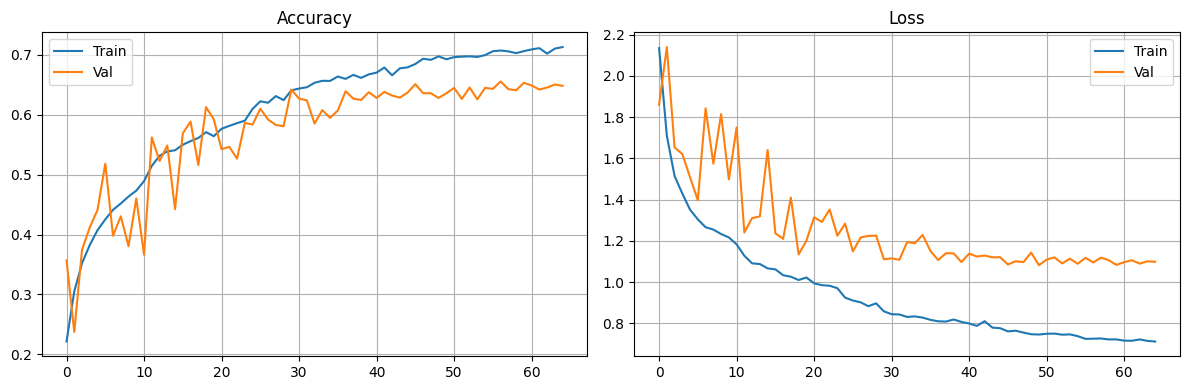

In [48]:
import matplotlib.pyplot as plt

def plot_history(h):
    plt.figure(figsize=(12,4))
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='Train')
    plt.plot(h.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.legend(); plt.grid(True)
    # loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='Train')
    plt.plot(h.history['val_loss'], label='Val')
    plt.title('Loss'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "training_curves.png"), dpi=300)
    plt.show()

plot_history(history)

# 8 EVALUATION + CONFUSION MATRIX


Test accuracy: 0.6359 (63.59%)
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report
              precision    recall  f1-score   support

       angry       0.77      0.69      0.73       585
        calm       0.68      0.95      0.79        38
     fearful       0.55      0.55      0.55       293
       happy       0.53      0.58      0.55       293
     neutral       0.62      0.79      0.70       237
         sad       0.56      0.48      0.52       293
   surprised       0.88      0.79      0.83        38

    accuracy                           0.64      1777
   macro avg       0.66      0.69      0.67      1777
weighted avg       0.64      0.64      0.64      1777



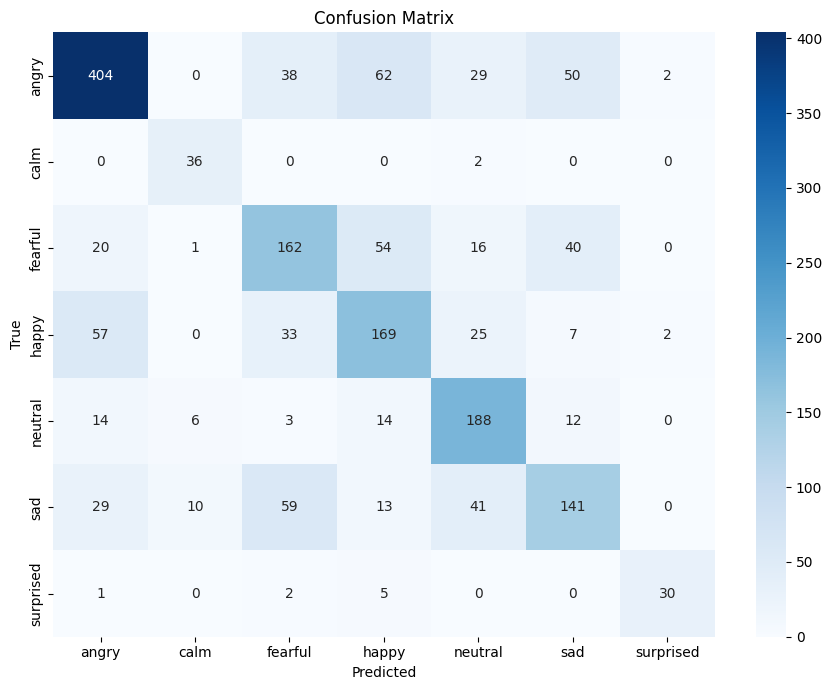

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Use y_test_onehot for evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

y_pred = np.argmax(model.predict(X_test), axis=1)

# Use y_test_encoded for y_true
y_true = y_test_encoded

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=classes))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), dpi=300)
plt.show()

# 9 SAVE FINAL MODEL

In [39]:
model.save(os.path.join(SAVE_DIR, "speech_emotion_cnn_final.h5"))
print("Final model saved!")

Final model saved!
